In [5]:
###################################################################################################
#
# Copyright (C) 2022 Maxim Integrated Products, Inc. All Rights Reserved.
#
# Maxim Integrated Products, Inc. Default Copyright Notice:
# https://www.maximintegrated.com/en/aboutus/legal/copyrights.html
#
###################################################################################################

import os
import sys

import numpy as np
import torch

import matplotlib.patches as patches
import matplotlib.pyplot as plt

sys.path.append(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'models'))

from collections import OrderedDict

import ai8x
from datasets import svhn
from utils import parse_obj_detection_yaml

import parse_qat_yaml

from distiller import apputils

ai85net_tinierssd = __import__("ai85net-tinierssd")

%matplotlib inline

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#CHANGE ME: Change below path to folder that contains or will contain dataset
#           (Data loader will create and use PascalVOC folder ubder this main root folder)
#           Below is an example where a path under Ubuntu root folder ('/'): /data2/ml/ 
#           is used for data files'
data_path = os.path.join(os.path.dirname('/'), 'data')

class Args:
    def __init__(self, act_mode_8bit):
        self.act_mode_8bit = act_mode_8bit
        self.truncate_testset = False

args = Args(act_mode_8bit=False)

_, test_set = svhn.SVHN_74_get_datasets((data_path, args), load_train=False, load_test=True)


In [7]:
num_classes = 11

qat_yaml_file_used_in_training = os.path.join(os.path.dirname(os.getcwd()), 'policies', 'qat_policy_svhn.yaml')
qat_policy = parse_qat_yaml.parse(qat_yaml_file_used_in_training)

ai8x.set_device(85, False, False)

model = ai85net_tinierssd.ai85tinierssd(num_classes=num_classes, device=device)

# Run training first, using scripts/train_svhn_tinierssd.sh
checkpoint_path = '../../ai8x-synthesis/trained/ai85-svhn-tinierssd-qat8.pth.tar'

# Fuse the BN parameters into conv layers before Quantization Aware Training (QAT)
ai8x.fuse_bn_layers(model)

# Switch model from unquantized to quantized for QAT
ai8x.initiate_qat(model, qat_policy)

model = apputils.load_lean_checkpoint(model, checkpoint_path, model_device=device)
ai8x.update_model(model)

model = model.to(device)

{'start_epoch': 25, 'weight_bits': 8, 'shift_quantile': 0.995}
Configuring device: MAX78000, simulate=False.


In [8]:
obj_detection_params_yaml_file = os.path.join(os.path.dirname(os.getcwd()), 'parameters', 'obj_detection_params_svhn.yaml')
obj_detection_params = parse_obj_detection_yaml.parse(obj_detection_params_yaml_file)

{'multi_box_loss': {'alpha': 2, 'neg_pos_ratio': 3}, 'nms': {'min_score': 0.2, 'max_overlap': 0.3, 'top_k': 20}}


In [9]:
selected_idx = 345 #np.random.randint(len(test_set))

img, (boxes, lbls) = test_set[selected_idx]
img = img.to(device)
img_to_plot = ((128*(img.detach().cpu().numpy()+1))).astype(np.uint8)
img_to_plot = img_to_plot.transpose([1,2,0])

img_model = img.unsqueeze(0)
locs, scores = model(img_model)

all_images_boxes, all_images_labels, all_images_scores = \
    model.detect_objects(locs, scores,
                         min_score=obj_detection_params['nms']['min_score'],
                         max_overlap=obj_detection_params['nms']['max_overlap'],
                         top_k=obj_detection_params['nms']['top_k'])


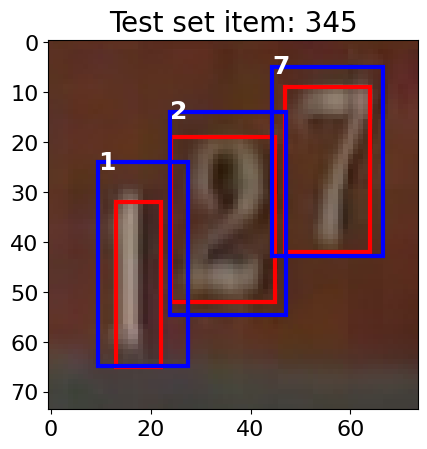

In [10]:
fig, ax = plt.subplots(1)
ax.imshow(img_to_plot)

plt.tick_params(labelsize=16)
        
subplot_title=("Test set item: " + str(selected_idx))
ax.set_title(subplot_title, fontsize = 20)

# Truth boxes
boxes_resized = [[box_coord * test_set.resize_size[0] for box_coord in box] for box in boxes]
for b in range(len(boxes)):
    bb = boxes_resized[b]
    rect = patches.Rectangle((bb[0], bb[1]), bb[2] - bb[0], bb[3] - bb[1], linewidth=3,
                            edgecolor='r', facecolor="none")
    ax.add_patch(rect)

# Predicted boxes
boxes_resized = [[box_coord * test_set.resize_size[0] for box_coord in box.detach().cpu().numpy()] for box in all_images_boxes]
detected_labels = [val.item() if val.item() != 10 else 0 for val in all_images_labels[0]]
for b in range(len(boxes_resized[0])):
    if(detected_labels[b] != 0):
        bb = boxes_resized[0][b]
        rect = patches.Rectangle((bb[0], bb[1]), bb[2] - bb[0], bb[3] - bb[1], linewidth=3,
                                edgecolor='b', facecolor="none")
        
        ax.text(bb[0],(bb[1]), detected_labels[b], verticalalignment='center', color='white', fontsize=18, weight='bold')
        ax.add_patch(rect)    
plt.show()